In [1]:
import tarfile
import codecs
import numpy as np 
import pandas as pd
from io import BytesIO
import json
import re
import altair as alt
import itertools
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from collections import Counter
from wordcloud import WordCloud
import gensim
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_union
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [2]:
from google.colab import drive
drive.mount('/content/data586_Project')

Mounted at /content/data586_Project


**Describe Dataset**

Response variable: Label - Either the log is normal or anomaly

In [ ]:
df = pd.read_csv('/content/data586_Project/MyDrive/DATA586_Project/processed_log.csv')
df.head()

,Date,Time,Pid,Level,Component,Content,BlockId
0,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,1608999687919862906
1,81109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,1608999687919862906
2,81109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,1608999687919862906
3,81109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,1608999687919862906
4,81109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,1608999687919862906


In [ ]:
df.BlockId.nunique()

575061

In [ ]:
event_description=[]
for line in df.Content:
  # extract only character add description of the event 
  match=re.findall('[a-zA-Z]+',str(line))
  event_description.append(match[0:6])

In [ ]:
df['Event_Description'] = event_description

In [ ]:
df.to_csv('event_desc.csv', index=False)

In [3]:
df = pd.read_csv('/content/data586_Project/MyDrive/DATA586_Project/event_desc.csv')

In [4]:
df['Event_id'] = df.groupby('Event_Description').ngroup()

In [5]:
df_event = df.iloc[:, 6:8].copy()
df_event.head()

,BlockId,Event_Description
0,1608999687919862906,"['Receiving', 'block', 'blk', 'src', 'dest']"
1,1608999687919862906,"['BLOCK', 'NameSystem', 'allocateBlock', 'mnt'..."
2,1608999687919862906,"['Receiving', 'block', 'blk', 'src', 'dest']"
3,1608999687919862906,"['Receiving', 'block', 'blk', 'src', 'dest']"
4,1608999687919862906,"['PacketResponder', 'for', 'block', 'blk', 'te..."


In [6]:
df_event = df.groupby('BlockId')['Event_Description'].apply(sum).reset_index(name='Events')
df_event.head()

,BlockId,Events
0,24807389905763,"['BLOCK', 'NameSystem', 'allocateBlock', 'user..."
1,27644297472372,"['Receiving', 'block', 'blk', 'src', 'dest']['..."
2,33380551139732,"['BLOCK', 'NameSystem', 'allocateBlock', 'user..."
3,35641716531335,"['BLOCK', 'NameSystem', 'allocateBlock', 'user..."
4,40083153975957,"['Receiving', 'block', 'blk', 'src', 'dest']['..."


In [7]:
df_event['Events'] = df_event['Events'].apply(lambda x: x.replace('][',','))
df_event['Events'] = df_event['Events'].apply(lambda x: x.replace("'",""))
df_event['Events'] = df_event['Events'].apply(lambda x: x.replace(" ",""))

In [8]:
df_event['Events'] = df_event['Events'].apply(lambda x: x[1:-1].split(','))
# df_event['Events'] = df_event['Events'].apply(lambda x: x.replace("\n","").replace('\r', ''))

In [9]:
events = []
for event in df_event["Events"]:
  events.append(event)

In [ ]:
df_event.to_csv('BlockId_events.csv', index=False)

In [10]:
df = pd.read_csv('/content/data586_Project/MyDrive/DATA586_Project/BlockId_events.csv')
df.head()

,BlockId,Events
0,24807389905763,"['BLOCK', 'NameSystem', 'allocateBlock', 'user..."
1,27644297472372,"['Receiving', 'block', 'blk', 'src', 'dest', '..."
2,33380551139732,"['BLOCK', 'NameSystem', 'allocateBlock', 'user..."
3,35641716531335,"['BLOCK', 'NameSystem', 'allocateBlock', 'user..."
4,40083153975957,"['Receiving', 'block', 'blk', 'src', 'dest', '..."


In [11]:
label = pd.read_csv('/content/data586_Project/MyDrive/DATA586_Project/anomaly_label.csv')

In [12]:
label['BlockId2'] = label.BlockId.str.extract('(\d+)') 
label.drop('BlockId', axis=1, inplace=True)

In [13]:
label.BlockId2 = pd.to_numeric(label.BlockId2, errors='coerce').fillna(0).astype(np.int64)

In [14]:
log = pd.merge(df_event, label, left_on='BlockId', right_on='BlockId2', how='left').drop('BlockId2', axis=1)
log.head()

,BlockId,Events,Label
0,24807389905763,"[BLOCK, NameSystem, allocateBlock, user, root,...",Normal
1,27644297472372,"[Receiving, block, blk, src, dest, Receiving, ...",Normal
2,33380551139732,"[BLOCK, NameSystem, allocateBlock, user, root,...",Normal
3,35641716531335,"[BLOCK, NameSystem, allocateBlock, user, root,...",Normal
4,40083153975957,"[Receiving, block, blk, src, dest, BLOCK, Name...",Normal


In [ ]:
len(log)

575061

In [ ]:
print(log.Events[1])

['Receiving', 'block', 'blk', 'src', 'dest', 'Receiving', 'block', 'blk', 'src', 'dest', 'Receiving', 'block', 'blk', 'src', 'dest', 'BLOCK', 'NameSystem', 'allocateBlock', 'user', 'root', 'sortrand', 'PacketResponder', 'for', 'block', 'blk', 'terminating', 'Received', 'block', 'blk', 'of', 'size', 'from', 'PacketResponder', 'for', 'block', 'blk', 'terminating', 'Received', 'block', 'blk', 'of', 'size', 'from', 'PacketResponder', 'for', 'block', 'blk', 'terminating', 'Received', 'block', 'blk', 'of', 'size', 'from', 'BLOCK', 'NameSystem', 'addStoredBlock', 'blockMap', 'updated', 'is', 'BLOCK', 'NameSystem', 'addStoredBlock', 'blockMap', 'updated', 'is', 'BLOCK', 'NameSystem', 'addStoredBlock', 'blockMap', 'updated', 'is', 'BLOCK', 'NameSystem', 'delete', 'blk', 'is', 'added', 'BLOCK', 'NameSystem', 'delete', 'blk', 'is', 'added', 'BLOCK', 'NameSystem', 'delete', 'blk', 'is', 'added', 'Deleting', 'block', 'blk', 'file', 'mnt', 'hadoop', 'Deleting', 'block', 'blk', 'file', 'mnt', 'hadoop

In [ ]:
log.groupby('Label').count()

,BlockId,Events
Label,,
Anomaly,16838,16838
Normal,558223,558223


# **Word2vec Training - Vector Averaging**

In [15]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(events, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

model.init_sims(replace=True)

word2vec_1 = "word2vec_origin"
model.save(word2vec_1)

2021-05-06 05:43:51,309 : INFO : collecting all words and their counts
2021-05-06 05:43:51,311 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-05-06 05:43:51,484 : INFO : PROGRESS: at sentence #10000, processed 1088731 words, keeping 69 word types


Training model...


2021-05-06 05:43:51,663 : INFO : PROGRESS: at sentence #20000, processed 2176989 words, keeping 73 word types
2021-05-06 05:43:51,847 : INFO : PROGRESS: at sentence #30000, processed 3262924 words, keeping 74 word types
2021-05-06 05:43:52,008 : INFO : PROGRESS: at sentence #40000, processed 4346954 words, keeping 75 word types
2021-05-06 05:43:52,173 : INFO : PROGRESS: at sentence #50000, processed 5428037 words, keeping 75 word types
2021-05-06 05:43:52,347 : INFO : PROGRESS: at sentence #60000, processed 6515740 words, keeping 76 word types
2021-05-06 05:43:52,512 : INFO : PROGRESS: at sentence #70000, processed 7601043 words, keeping 78 word types
2021-05-06 05:43:52,682 : INFO : PROGRESS: at sentence #80000, processed 8690870 words, keeping 78 word types
2021-05-06 05:43:52,851 : INFO : PROGRESS: at sentence #90000, processed 9773669 words, keeping 78 word types
2021-05-06 05:43:53,013 : INFO : PROGRESS: at sentence #100000, processed 10862826 words, keeping 78 word types
2021-05-

In [16]:
from gensim.models import Word2Vec
model = Word2Vec.load("word2vec_origin")
model.wv.syn0.shape

2021-05-06 05:47:24,441 : INFO : loading Word2Vec object from word2vec_origin
2021-05-06 05:47:24,447 : INFO : loading wv recursively from word2vec_origin.wv.* with mmap=None
2021-05-06 05:47:24,449 : INFO : setting ignored attribute vectors_norm to None
2021-05-06 05:47:24,450 : INFO : loading vocabulary recursively from word2vec_origin.vocabulary.* with mmap=None
2021-05-06 05:47:24,451 : INFO : loading trainables recursively from word2vec_origin.trainables.* with mmap=None
2021-05-06 05:47:24,453 : INFO : setting ignored attribute cum_table to None
2021-05-06 05:47:24,455 : INFO : loaded word2vec_origin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(67, 300)

In [17]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given block id

    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0

    index2word_set = set(model.wv.index2word)

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])

    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(ids, model, num_features):
    # Given a set of ids calculate the average feature vector for each one

    counter = 0
    idFeatureVecs = np.zeros((len(ids), num_features), dtype="float32")

    for element in ids:

       if counter%10000 == 0:
           print("Block id %d of %d" % (counter, len(ids)))

       # Call the function that makes average feature vectors
       idFeatureVecs[counter] = makeFeatureVec(element, model, num_features)

       counter = counter + 1
    return idFeatureVecs

# **Parse HDFS.2K Sample Set**

In [18]:
with open('/content/data586_Project/MyDrive/DATA586_Project/HDFS_2k.log') as f:
    data = f.readlines()

In [ ]:
test_log = [t.strip() for t in data]
Date = []
Time = []
Pid = []
Level = []
Component = []
Content = []

In [ ]:
for line in test_log:
  s1=line.split(' ')[0].strip()
  Date.append(s1)
  s2=line.split(' ')[1].strip()
  Time.append(s2)
  s3=line.split(' ')[2].strip()
  Pid.append(s3)
  s4=line.split(' ')[3].strip()
  Level.append(s4)
  s5=line.split(' ')[4].strip(': ')
  Component.append(s5)
  s6=line.split(' ')[5:]
  Content.append(' '.join(s6))

In [ ]:
test = pd.DataFrame([Date, Time, Pid, Level, Component, Content])
test = test.T
test.columns=['Date','Time', 'Pid', 'Level', 'Component', 'Content']

In [ ]:
test['BlockId'] = test.Content.str.extract(r'(?:blk_-)(\d+)')
test['BlockId2'] = test.Content.str.extract(r'(?:blk_)(\d+)')

In [ ]:
test['BlockId'] = test['BlockId'].fillna(test['BlockId2'])
test.drop('BlockId2', axis=1, inplace=True)
test.head()

,Date,Time,Pid,Level,Component,Content,BlockId
0,081109,203615,148,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_38865049064139...,38865049064139660
1,081109,203807,222,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_-6952295868487...,6952295868487656571
2,081109,204005,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...,7128370237687728475
3,081109,204015,308,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_82291938032499...,8229193803249955061
4,081109,204106,329,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_-6670958622368...,6670958622368987959


In [ ]:
test_event=[]
for line in test.Content:
  # extract only character add description of the event 
  match=re.findall('[a-zA-Z]+',str(line))
  test_event.append(match[0:6])

In [ ]:
test['Event_Description'] = test_event

In [ ]:
test_event = test.iloc[:, 6:8].copy()
test_event.head()

,BlockId,Event_Description
0,38865049064139660,"[PacketResponder, for, block, blk, terminating]"
1,6952295868487656571,"[PacketResponder, for, block, blk, terminating]"
2,7128370237687728475,"[BLOCK, NameSystem, addStoredBlock, blockMap, ..."
3,8229193803249955061,"[PacketResponder, for, block, blk, terminating]"
4,6670958622368987959,"[PacketResponder, for, block, blk, terminating]"


In [ ]:
test_event = test_event.groupby('BlockId')['Event_Description'].apply(sum).reset_index(name='Events')
test_event.head()

,BlockId,Events
0,1002945451269828722,"[PacketResponder, for, block, blk, terminating]"
1,1018961650823645078,"[Deleting, block, blk, file, mnt, hadoop]"
2,1021828391502582165,"[BLOCK, NameSystem, addStoredBlock, blockMap, ..."
3,102441832197223997,"[Receiving, block, blk, src, dest]"
4,1030832046197982436,"[BLOCK, NameSystem, delete, blk, is, added]"


In [ ]:
test_event.Events[0]

['PacketResponder', 'for', 'block', 'blk', 'terminating']

In [ ]:
test = []
for event in test_event["Events"]:
  test.append(event)

# **Prediction**

In [20]:
trainDataVecs = getAvgFeatureVecs(events, model, num_features )

Block id 0 of 575061


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


Block id 10000 of 575061
Block id 20000 of 575061
Block id 30000 of 575061
Block id 40000 of 575061
Block id 50000 of 575061
Block id 60000 of 575061
Block id 70000 of 575061
Block id 80000 of 575061
Block id 90000 of 575061
Block id 100000 of 575061
Block id 110000 of 575061
Block id 120000 of 575061
Block id 130000 of 575061
Block id 140000 of 575061
Block id 150000 of 575061
Block id 160000 of 575061
Block id 170000 of 575061
Block id 180000 of 575061
Block id 190000 of 575061
Block id 200000 of 575061
Block id 210000 of 575061
Block id 220000 of 575061
Block id 230000 of 575061
Block id 240000 of 575061
Block id 250000 of 575061
Block id 260000 of 575061
Block id 270000 of 575061
Block id 280000 of 575061
Block id 290000 of 575061
Block id 300000 of 575061
Block id 310000 of 575061
Block id 320000 of 575061
Block id 330000 of 575061
Block id 340000 of 575061
Block id 350000 of 575061
Block id 360000 of 575061
Block id 370000 of 575061
Block id 380000 of 575061
Block id 390000 of 57

In [ ]:
from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [word for word in model.wv.vocab ]
        
    word_vectors = np.array([model.wv[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(10,7))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

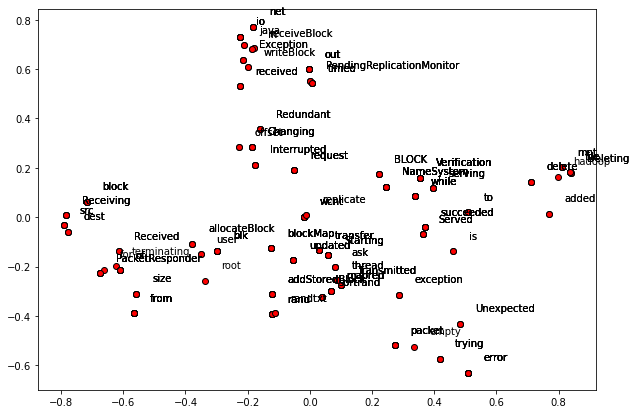

In [22]:
display_pca_scatterplot(model, sample=300)

In [ ]:
num_features = 300
testDataVecs = getAvgFeatureVecs(test, model, num_features)

Block id 0 of 1994


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


# **Random Forest**

**Split the HDFS.1**

In [23]:
X = trainDataVecs
y = log.iloc[:, 2]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)

In [25]:
y_train.value_counts()

Normal     446525
Anomaly     13523
Name: Label, dtype: int64

In [26]:
y_test.value_counts()

Normal     111698
Anomaly      3315
Name: Label, dtype: int64

In [ ]:
# Train the model
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)

# Prediction
y_pred = classifier.predict(X_test)

In [ ]:
# Evaluate model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[  3311      4]
 [     5 111693]]
              precision    recall  f1-score   support

     Anomaly       1.00      1.00      1.00      3315
      Normal       1.00      1.00      1.00    111698

    accuracy                           1.00    115013
   macro avg       1.00      1.00      1.00    115013
weighted avg       1.00      1.00      1.00    115013

0.9999217479763157


In [ ]:
# Save model

with open('RF_W2V_AVG_classifier', 'wb') as picklefile:
    pickle.dump(classifier,picklefile)

In [ ]:
# Load model

with open('RF_BW_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

# **Logistic Regression**

In [ ]:
# Train the model
classifier = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
classifier.fit(X_train, y_train)

# Prediction
y_pred = classifier.predict(X_test)

[LibLinear]

In [ ]:
# Evaluate model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[  1507   1808]
 [    70 111628]]
              precision    recall  f1-score   support

     Anomaly       0.96      0.45      0.62      3315
      Normal       0.98      1.00      0.99    111698

    accuracy                           0.98    115013
   macro avg       0.97      0.73      0.80    115013
weighted avg       0.98      0.98      0.98    115013

0.9836714110578804


# **Word2vec Training - Clustering**

In [35]:
from sklearn.cluster import KMeans

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an average of 5 words per cluster
word_vectors = model.wv.syn0
num_clusters = word_vectors.shape[0] // 5

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


In [ ]:
                                                                                           
word_centroid_map = dict(zip(model.wv.index2word, idx))

In [ ]:
# For the first 10 clusters
for cluster in range(0,10):
  
    print ("\nCluster %d" % cluster)

    words = []
    for i in range(0,len(word_centroid_map.values())):
        if(list(word_centroid_map.values())[i] == cluster):
          words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['to', 'Served', 'exception', 'Got', 'while', 'serving', 'Verification']

Cluster 1
['blk', 'block', 'for', 'src', 'dest', 'Receiving', 'of', 'Received', 'PacketResponder', 'terminating', 'from', 'size', 'allocateBlock', 'user', 'root']

Cluster 2
['Exception', 'in', 'receiveBlock', 'Changing', 'offset', 'net', 'Interrupted']

Cluster 3
['received', 'Redundant']

Cluster 4
['transfer', 'ask', 'Starting', 'thread', 'Transmitted']

Cluster 5
['BLOCK', 'mnt', 'hadoop', 'file', 'Deleting', 'delete', 'added', 'succeeded']

Cluster 6
['NameSystem', 'is', 'blockMap', 'updated']

Cluster 7
['trying', 'empty', 'packet']

Cluster 8
['rand', 'randtxt', 'sortrand', 'wcnt', 'mapred']

Cluster 9
['PendingReplicationMonitor', 'timed', 'out']


# **Bag of Words**

In [ ]:
normal = log[log['Label'] == 'Normal']
anomaly = log[log['Label'] == 'Anomaly']

In [ ]:
items = (log['Event_Description'].unique())

In [ ]:
data_dtm=data_dtm.transpose()

top_dict = {}
for i in data_dtm.columns:
  top = data_dtm[i].sort_values(ascending=False).head(20)
  top_dict[i]=list(zip(top.index,top.values))

In [ ]:
words =[]

for x in data_dtm.columns:
  top = [word for (word, count) in top_dict[x]]
  for t in top:
    words.append(t)

In [ ]:
stop_words = [word for word,count in Counter(words).most_common() if count>575061*0.7]

# **Random Forest - Using Bag of Words**

In [27]:
data_dtm = pd.read_pickle("/content/data586_Project/MyDrive/DATA586_Project/dtm.pkl")

In [28]:
data_dtm.reset_index(inplace=True)
data_dtm.head(10)

,BlockId,Label,added,adding,addstoredblock,allocateblock,ask,belong,blk,block,blockinfo,blockmap,broken,ch,changing,channel,channels,closed,closedbyinterruptexception,conf,connected,connection,current,data,datanode,delete,deleting,dest,dfs,does,ec,eofexception,error,exception,existing,failed,file,got,grep,grepa,...,served,serving,size,socketchannel,sockettimeoutexception,sort,sorter,sortrand,split,src,starting,stream,subdir,succeeded,task,temp,temporary,terminating,text,thread,timed,timeout,transfer,transmitted,trying,unexpected,updated,user,valid,verification,volumemap,waiting,wcnt,wordcount,write,writeblock,writer,writing,written,xml
0,24807389905763,Normal,6,0,3,1,0,0,22,19,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,3,3,0,0,0,0,0,0,0,3,0,0,0,...,0,0,6,0,0,0,0,1,0,3,0,0,3,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
1,27644297472372,Normal,6,0,3,1,0,0,22,19,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,3,3,0,0,0,0,0,0,0,3,0,0,0,...,0,0,6,0,0,0,0,1,0,3,0,0,3,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
2,33380551139732,Normal,6,0,3,1,0,0,34,27,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,3,3,0,0,0,0,4,0,0,3,4,0,0,...,8,4,6,0,0,0,0,0,0,3,0,0,3,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
3,35641716531335,Normal,6,0,3,1,0,0,22,19,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,3,3,0,0,0,0,0,0,0,3,0,0,0,...,0,0,6,0,0,0,0,0,0,3,0,0,3,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
4,40083153975957,Normal,6,0,3,1,0,0,22,19,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,3,3,0,0,0,0,0,0,0,3,0,0,0,...,0,0,6,0,0,0,0,0,0,3,0,0,3,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
5,72472557232301,Normal,6,0,3,1,0,0,22,19,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,3,3,0,0,0,0,0,0,0,3,0,0,0,...,0,0,6,0,0,0,0,0,0,3,0,0,3,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
6,72859758335309,Normal,6,0,3,1,0,0,22,19,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,3,3,3,3,0,0,0,0,0,0,0,3,0,0,0,...,0,0,6,0,0,0,0,0,0,3,0,0,3,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
7,78222097481044,Normal,3,0,3,1,0,0,13,13,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,3,0,0,0,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
8,97457323857639,Normal,3,0,3,1,0,0,13,13,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,3,0,0,0,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
9,99286907018543,Normal,3,0,3,1,0,0,13,13,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,3,0,0,0,0,1,0,1,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
label_col = {'Normal': 1, 'Anomaly': 0}

data_dtm.Label = [label_col[item] for item in data_dtm.Label]

In [30]:
y = data_dtm.iloc[:, 2]
X = data_dtm.iloc[:, 3:]